In [6]:
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display

### U-Net diffusion model

In [74]:
class U_Net(Model):

    def __init__(self, image_shape, num_channels, emb_dim=512, gate_filters=32, num_resolutions=4, attn_res_idx=2):
        super().__init__()
        
        self.image_shape = image_shape
        self.num_channels = num_channels
        self.num_resolutions = num_resolutions
        self.attn_res_idx = attn_res_idx
        self.emb_dim = emb_dim
        self.gate_filters = gate_filters
        self.build_graph()
        
    def timestep_embedding(self, ts, embedding_dim):
        assert len(ts.shape)==1
        
        half_dim = embedding_dim // 2
        emb = -(tf.math.log(10000.0)/(half_dim-1))
        
        idxs = tf.range(half_dim, dtype=tf.float32)
        emb = tf.math.exp(idxs*emb)
        
        ts = tf.cast(ts, dtype=tf.float32)
        
        emb = ts[:,None]* emb[None,:]
        
        pe = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        
        return pe
    
    def nonlinearity(self, x):
        return tf.keras.activations.swish(x)
    
    def normalize(self, x):
        return tfa.layers.InstanceNormalization(axis=-1)(x)
        
    def ResBlK(self, x, temb):
        h = self.nonlinearity(self.normalize(x))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        temb = self.nonlinearity(temb)
        h +=  tf.reshape(layers.Dense(h.shape[-1])(temb), (-1, 1, 1,h.shape[-1]))
        
        h = self.nonlinearity(self.normalize(h))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        return x+h
        
    def downsample(self, x, filters, factor=2):
        return layers.Conv2D(filters, (3, 3),
                                        strides=(factor, factor), padding='same')(x)

    def upsample(self, x, filters, factor=2):
        return layers.Conv2DTranspose(filters, (3, 3),
                                       strides=(factor, factor), padding='same')(x)
        
    def NonlocalGaussian(self, x):
        h = self.normalize(x)
        theta = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        g = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = tf.transpose(phi, (0, 3, 2, 1))

        theta = tf.reshape(theta, shape=(-1, theta.shape[1]*theta.shape[2], theta.shape[3]))

        phi = tf.reshape(phi, shape=(-1, phi.shape[1], phi.shape[2]*phi.shape[3]))
        g = tf.reshape(g, shape=(-1, g.shape[1]*g.shape[2], g.shape[3]))
        
        f = tf.matmul(theta, phi)
        
        f = layers.Softmax()(f)
        
        y = tf.matmul(f, g)
        
        y = tf.reshape(y, (-1, x.shape[1], x.shape[2], y.shape[-1]))
        
        z = tf.math.add(x, layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(y))
        return z
    
    def call(self, img_input, t):
        
        temb = self.timestep_embedding(t, self.emb_dim)
        
        hs = [layers.Conv2D(self.gate_filters, (1, 1),
                                        strides=(1, 1), padding='same')(img_input)]
        for i in range(self.num_resolutions):
            h = self.ResBlK(hs[-1], temb)
            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != self.num_resolutions - 1:
                h = self.downsample(h, h.shape[-1]*2)
                
            hs.append(h)

        h = hs[-1]
        h = self.ResBlK(h, temb)
        h = self.NonlocalGaussian(h)
        h = self.ResBlK(h, temb)
                
        for i in reversed(range(self.num_resolutions)):
            h = h+hs[i]
            h = self.ResBlK(h, temb)

            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != 0:
                h = self.upsample(h, h.shape[-1]//2)
        
                
        h = self.nonlinearity(self.normalize(h))
        
        h = layers.Conv2D(self.num_channels, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        
        return h
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channels))
        
        t = layers.Input(shape=())
        
        return Model(inputs=[x,t], outputs=self.call(x,t))
        

In [75]:
u_net1 = U_Net((64,64), 3)

In [76]:
img_in = tf.random.normal((3, 64,64,3))
t = tf.random.uniform((3,),maxval=1000, dtype=tf.int32)
img_in.shape, t

(TensorShape([3, 64, 64, 3]),
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([684, 491, 294], dtype=int32)>)

In [77]:
u_net1(img_in, t)

<tf.Tensor: shape=(3, 64, 64, 3), dtype=float32, numpy=
array([[[[ 4.47280891e-02,  3.81142944e-01, -3.72391909e-01],
         [-7.53104150e-01, -5.77561438e-01,  1.56966701e-01],
         [-1.50939390e-01, -7.42086321e-02,  6.74418926e-01],
         ...,
         [ 2.03884631e-01, -5.19561991e-02,  1.91220592e-04],
         [-5.45514166e-01, -5.36142051e-01, -1.83959417e-02],
         [-2.69531190e-01,  1.90698411e-02, -3.01245719e-01]],

        [[ 7.56727874e-01, -4.54892218e-02, -5.66792309e-01],
         [ 2.30129376e-01, -4.18751389e-01, -1.77631229e-01],
         [-5.19687533e-01, -2.17430249e-01, -3.25429946e-01],
         ...,
         [-1.61905866e-02, -3.53094161e-01,  2.78343707e-01],
         [-5.21603346e-01, -5.09729743e-01, -2.19749942e-01],
         [-1.84252292e-01, -1.94713712e-01,  1.14963853e+00]],

        [[ 2.08306789e-01, -8.59631523e-02,  9.98591483e-01],
         [ 4.12318140e-01, -3.47990513e-01, -3.84973496e-01],
         [-6.44165933e-01,  5.25847018e-01, 

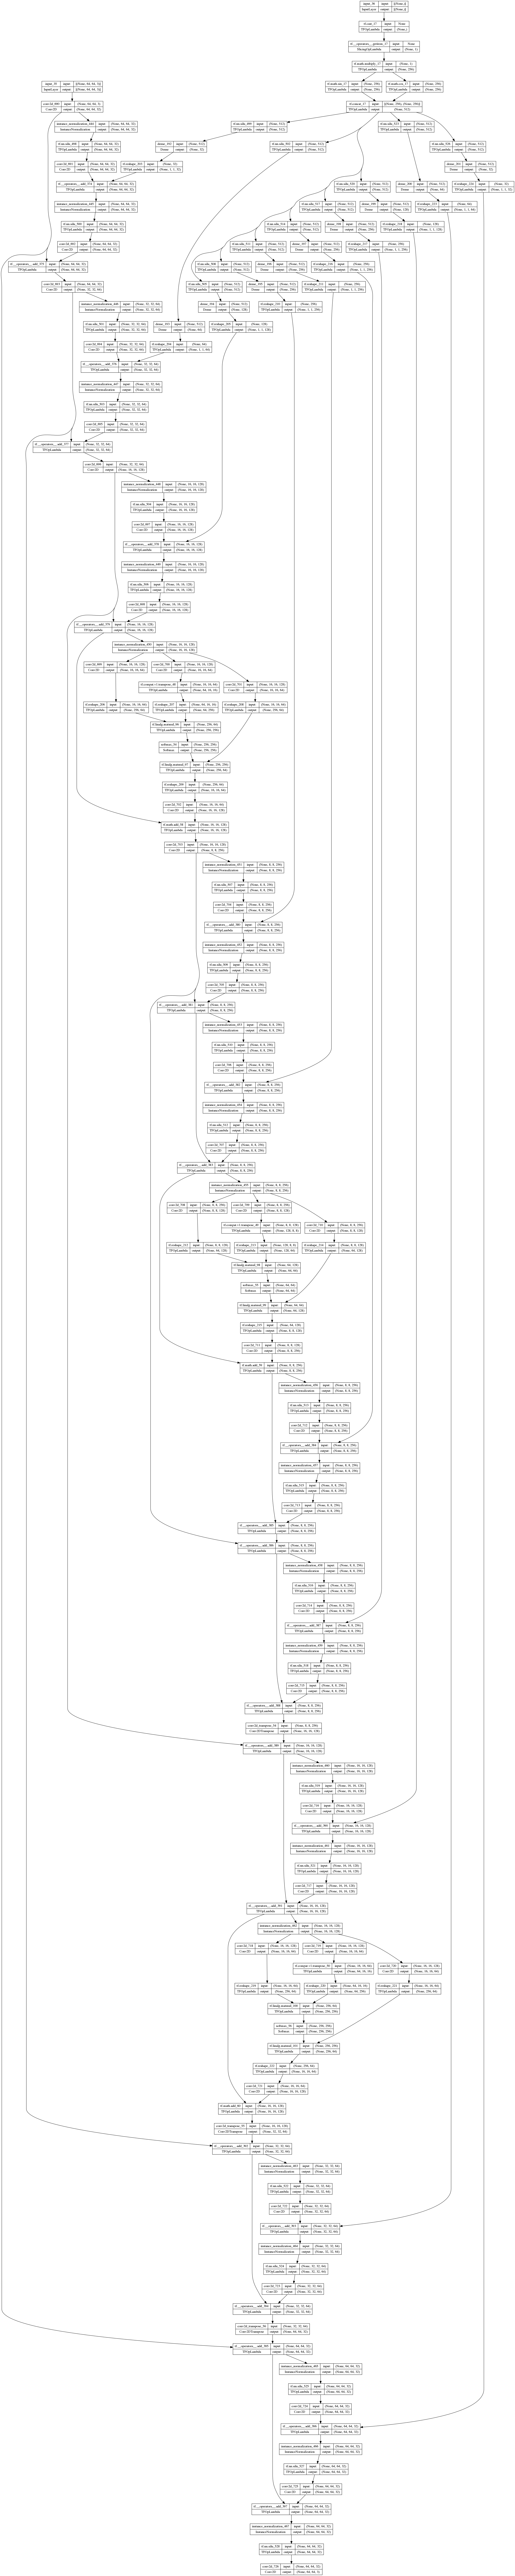

In [78]:
tf.keras.utils.plot_model(u_net1.build_graph(), show_shapes=True)

### Gaussian Diffusion

In [91]:
class GSDDPM:
    
    def __init__(self, image_shape, num_channel, dataset_path=None, timestamps=1000, beta_start=1e-4, beta_end=0.02,
                 batch_size=64, lr=3e-4):
        assert len(image_shape) == 2
        
        self.imgsp, self.nc, self.dp, self.ts, self.bs, self.lr = image_shape, num_channel, dataset_path, timestamps, batch_size, lr
        self.denoise_unet = U_Net(self.imgsp, self.nc)
        
        betas = self.get_betas(timestamps, beta_start, beta_end)
        
        alphas = 1. - betas
        alphas_cuprod = np.cumprod(alphas)
        alphas_cuprod_prev = np.append(1., alphas_cuprod[:-1])
        
        self.betas = tf.constant(betas)

        self.sqrt_alphas_cuprod = tf.constant(np.sqrt(alphas_cuprod))
        self.sqrt_one_minus_alphas_cuprod = tf.constant(np.sqrt(1. - alphas_cuprod))
#         self.log_one_minus_alphas_cuprod = tf.constant(np.log(1. - alphas_cuprod))
#         self.sqrt_recip_alphas_cuprod = tf.constant(np.sqrt(1. / alphas_cuprod))
#         self.sqrt_recipm1_alphas_cuprod = tf.constant(np.sqrt(1. / alphas_cuprod - 1))
    

    def get_betas(self, ts, bs, be):
        betas = np.linspace(bs, be, ts, dtype=np.float64)

        return betas
    
    def q_sample(self,xs, ts, epsilon): 
        return tf.gather(self.sqrt_alphas_cuprod, ts)*xs + tf.gather(self.sqrt_one_minus_alphas_cuprod, ts)*epsilon
        
    def p_losses(self, xs, ts):
        
        epsilon = tf.random_normal(shape=xs.shape, dtype=xs.dtype)
                               
        x_noisy = self.q_sample(xs=xs, ts=ts, epsilon=epsilon)
        x_recon = self.denoise_unet(x_noisy, ts)
                               
        losses = tf.reduce_mean(tf.squared_difference(noise, x_recon), axis=list(range(1, len(noise.shape))))

        return losses

    def p_sample_to_img(self):
        
        img_0 = tf.random.normal((self.imgsp[0], self.imgsp[1], self.nc))
        
        

In [83]:
dm1 = GSDDPM((64,64), 3)

In [89]:
a = tf.random.normal((10,))
b = tf.random.uniform((2,), maxval=10, dtype = tf.int32)

a, b, tf.gather(a, b)

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([-0.85895276, -0.36394864, -0.77714485,  1.2204664 , -1.0714644 ,
         0.8872212 , -0.00805322, -0.9441899 , -2.313625  , -1.0782591 ],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 0], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.00805322, -0.85895276], dtype=float32)>)

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([1.00005000e-02, 1.48309237e-02, 1.89696194e-02, 2.27966937e-02,
       2.64479604e-02, 2.99878926e-02, 3.34520384e-02, 3.68619542e-02,
       4.02316147e-02, 4.35705437e-02, 4.68854902e-02, 5.01813901e-02,
       5.34619489e-02, 5.67300112e-02, 5.99878026e-02, 6.32370938e-02,
       6.64793147e-02, 6.97156354e-02, 7.29470252e-02, 7.61742959e-02,
       7.93981340e-02, 8.26191261e-02, 8.58377775e-02, 8.90545271e-02,
       9.22697592e-02, 9.54838128e-02, 9.86969889e-02, 1.01909557e-01,
       1.05121759e-01, 1.08333814e-01, 1.11545922e-01, 1.14758265e-01,
       1.17971013e-01, 1.21184321e-01, 1.24398333e-01, 1.27613184e-01,
       1.30829003e-01, 1.34045907e-01, 1.37264009e-01, 1.40483418e-01,
       1.43704236e-01, 1.46926558e-01, 1.50150481e-01, 1.53376092e-01,
       1.56603480e-01, 1.59832727e-01, 1.63063916e-01, 1.66297125e-01,
       1.69532431e-01, 1.72769909e-01, 1.76009633e-01, 1.79251673e-01,
       1.82496102e-01, 1.857